# Business Understanding

Você trabalha em uma plataforma de streaming e a diretoria está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn. Seu objetivo é criar um modelo de classificação capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não. Para isso, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.

Compreender quem é o perfil que está aumentando o churn do seu negócio é essencial para tomar ações que reduzam essas perdas, seja alterando critérios na venda ou modificando o produto.

# Setup

In [218]:
# Data Wrangling
import pandas as pd
import numpy as np

# Visualizacao de dados
from yellowbrick.classifier import confusion_matrix
import seaborn as sns

# Pre processamento
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Selecao e validacao de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Output pandas
from sklearn import set_config
set_config(transform_output="pandas")

In [16]:
# Métricas dos dados de teste
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Balanced Accuracy': metrics.balanced_accuracy_score(y_true, y_pred),
        'Recall': metrics.recall_score(y_true, y_pred),
        'Precison': metrics.precision_score(y_true, y_pred),
        'F1': metrics.f1_score(y_true, y_pred),
        'ROC_AUC': metrics.roc_auc_score(y_true, y_pred)
    }
    return dict_metrics

# Data Understanding

In [219]:
# Carregando o dataset
df = pd.read_csv('streaming_data.csv')
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


In [18]:
# Descricão estatística dos dados
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


In [19]:
# Visualizando tipo dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [20]:
# Visualizando dados duplicados
df.duplicated().value_counts()

False    65481
True     12403
dtype: int64

In [21]:
# Visualizando dados nulos
df.isna().sum()

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64

In [22]:
# Verificando o número de pessoas Churn e Não Churn (dados desbalanceados)
churn_agg = df.groupby("Churned")['User_id'].count().reset_index()
churn_agg = pd.DataFrame(churn_agg)
churn_agg

,Churned,User_id
0,0.0,46285
1,1.0,14863


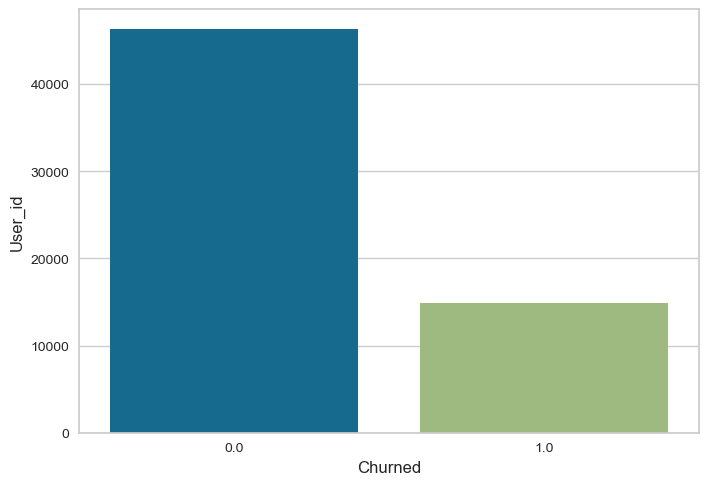

In [23]:
# Plot churned
sns.barplot(data=churn_agg, x = "Churned",y = "User_id");

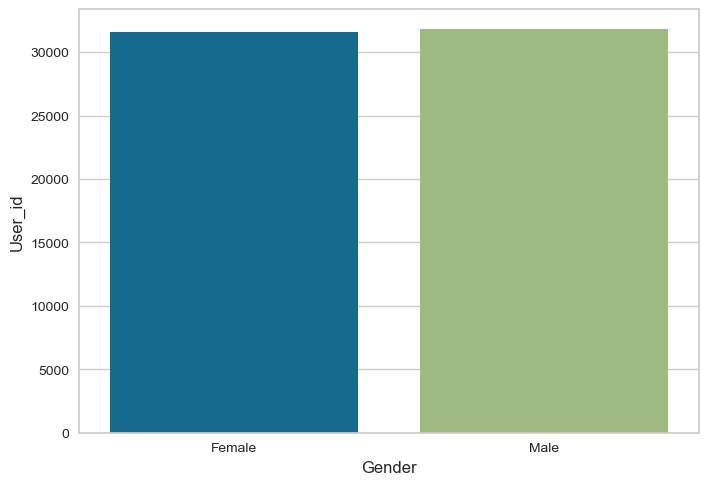

In [24]:
# Usuarios por genero
churn_agg_gender = df.groupby("Gender")['User_id'].count().reset_index()
churn_agg_gender = pd.DataFrame(churn_agg_gender)

# Plot usuarios
sns.barplot(data=churn_agg_gender, x = "Gender",y = "User_id");

# Data Preparation

In [25]:
# Preenchendo com 0 os valores NaN das colunas
columns = ['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']
df[columns] = df[columns].fillna(0)
    
df

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,0.0,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,0.0,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f
...,...,...,...,...,...,...,...,...,...,...
77879,45.0,Male,0.0,0.0,Basic,0.0,5,2.20,0.0,6b51fe0d-d4a1-41ed-a55c-d05f5c961e3c
77880,47.0,Female,6176.0,0.0,Premium,0.0,2,4.54,0.0,59d70167-6be0-474c-b71e-14153205b44f
77881,64.0,Female,0.0,5.0,Premium,0.0,1,4.34,1.0,a7d5ed26-78a4-4e70-bd04-0fec883e56aa
77882,58.0,Male,1314.0,5.0,Standard,0.0,4,0.00,0.0,472e9e70-87ca-4c5e-bfee-fa9f42b54f51


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        77884 non-null  float64
 3   Devices_connected       77884 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  77884 non-null  float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              77884 non-null  float64
 8   Churned                 77884 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [27]:
# Dropando valores nulos
df.dropna(inplace=True)
df

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,0.0,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54.0,Male,3024.0,2.0,Basic,0.0,1,0.00,0.0,a1df3a13-9255-4d00-8a9d-20565fefaab9
...,...,...,...,...,...,...,...,...,...,...
77879,45.0,Male,0.0,0.0,Basic,0.0,5,2.20,0.0,6b51fe0d-d4a1-41ed-a55c-d05f5c961e3c
77880,47.0,Female,6176.0,0.0,Premium,0.0,2,4.54,0.0,59d70167-6be0-474c-b71e-14153205b44f
77881,64.0,Female,0.0,5.0,Premium,0.0,1,4.34,1.0,a7d5ed26-78a4-4e70-bd04-0fec883e56aa
77882,58.0,Male,1314.0,5.0,Standard,0.0,4,0.00,0.0,472e9e70-87ca-4c5e-bfee-fa9f42b54f51


In [28]:
# Substituindo os valores da coluna Churned por Yes/No
df['Churned'].replace({0: 'No', 1: 'Yes'},  inplace=True)
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54.0,Male,3024.0,2.0,Basic,0.0,1,0.00,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [29]:
# Transformando os valores para inteiros
columns = ['Age', 'Time_on_platform', 'Devices_connected', 'Num_streaming_services', 'Avg_rating']
df[columns] = df[columns].astype('int64')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     36515 non-null  int64 
 1   Gender                  36515 non-null  object
 2   Time_on_platform        36515 non-null  int64 
 3   Devices_connected       36515 non-null  int64 
 4   Subscription_type       36515 non-null  object
 5   Num_streaming_services  36515 non-null  int64 
 6   Num_active_profiles     36515 non-null  int64 
 7   Avg_rating              36515 non-null  int64 
 8   Churned                 36515 non-null  object
 9   User_id                 36515 non-null  object
dtypes: int64(6), object(4)
memory usage: 3.1+ MB


In [40]:
# Definindo X e Y para os modelos
# Dropando a coluna User_id, pois não iria agregar nada ao modelo
X = df.drop(columns=['Churned', 'User_id'], axis=1)
y = df['Churned']

In [46]:
# Aplicando o LabelEncoder
le = LabelEncoder()

y = pd.DataFrame(y)
le.fit(y.Churned) 
y.Churned = le.transform(y.Churned)

In [48]:
# Aplicando o Get Dummies para as variáveis categóricas de X
X = pd.get_dummies(X)

In [49]:
# Aplicando a normalizacao MinMaxScaler
scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X))
X

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard
0,0.607843,0.536591,0.6,0.00,0.50,0.0,0.0,1.0,1.0,0.0,0.0
1,1.000000,0.697226,0.4,0.00,0.00,0.4,1.0,0.0,0.0,0.0,1.0
2,0.509804,0.727709,0.6,0.25,0.00,0.2,0.0,1.0,0.0,1.0,0.0
3,0.156863,0.000000,1.0,0.00,0.25,0.0,0.0,1.0,1.0,0.0,0.0
5,0.705882,0.345245,0.4,0.00,0.00,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
77879,0.529412,0.000000,0.0,0.00,1.00,0.4,0.0,1.0,1.0,0.0,0.0
77880,0.568627,0.705103,0.0,0.00,0.25,0.8,1.0,0.0,0.0,1.0,0.0
77881,0.901961,0.000000,1.0,0.00,0.00,0.8,1.0,0.0,0.0,1.0,0.0
77882,0.784314,0.150017,1.0,0.00,0.75,0.0,0.0,1.0,0.0,0.0,1.0


In [50]:
# Separando X e Y em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Modeling

## Logistic Regression

In [ ]:
# Treinando o modelo de Regressao Logistica para dados desbalanceados
model = LogisticRegression(class_weight='balanced')

lr = model.fit(X_train, y_train)

In [99]:
# Fazendo a predicão dos dados
lr_pred = lr.predict(X_test)

In [100]:
# Verificando a quantidade de churn e nao churn predita
pd.DataFrame(lr_pred).value_counts()

0    3773
1    3530
dtype: int64

In [101]:
# Dados com a coluna de predicão
X_test.assign(Churn = y_test).assign(Prediction = lr.predict(X_test))

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard,Churn,Prediction
70870,0.509804,0.897477,1.0,0.00,0.75,0.4,1.0,0.0,0.0,1.0,0.0,0,1
2,0.509804,0.727709,0.6,0.25,0.00,0.2,0.0,1.0,0.0,1.0,0.0,1,0
13024,0.137255,0.000000,1.0,1.00,0.25,0.6,1.0,0.0,0.0,0.0,1.0,0,1
48045,0.372549,0.710355,0.2,0.00,0.75,0.8,0.0,1.0,0.0,1.0,0.0,0,1
15668,0.431373,0.998858,1.0,0.00,0.75,0.6,1.0,0.0,0.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30909,0.019608,0.393081,0.6,0.00,0.50,0.6,1.0,0.0,1.0,0.0,0.0,0,1
59589,0.647059,0.709213,0.2,0.00,0.25,0.8,1.0,0.0,1.0,0.0,0.0,0,1
50113,0.490196,0.270693,0.8,0.00,0.00,0.4,0.0,1.0,0.0,0.0,1.0,0,0
57582,0.470588,0.259733,0.2,0.00,0.25,0.0,0.0,1.0,0.0,0.0,1.0,1,0


c:\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


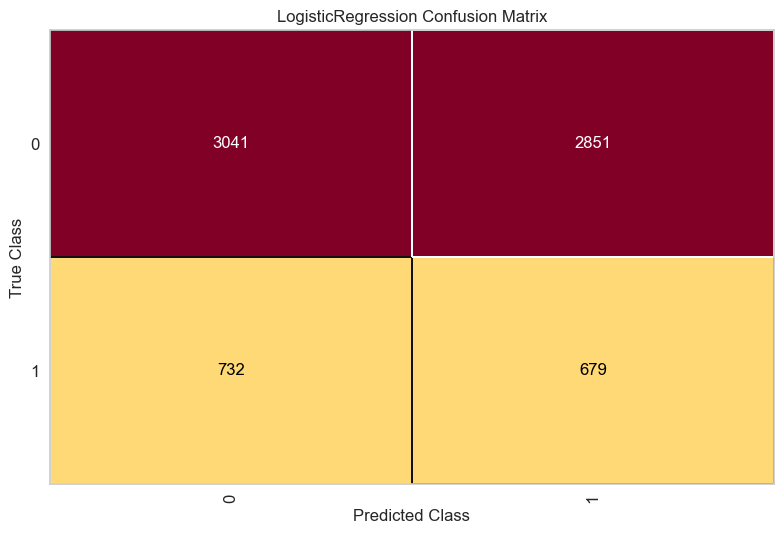

ConfusionMatrix(ax=<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x0000029A48B549A0>,
                estimator=LogisticRegression(class_weight='balanced'))

In [102]:
# Plotando a matriz de confusão
confusion_matrix(lr, X_train, y_train, X_test, y_test)

In [103]:
# Métricas dos dados para a Regressao Logistica
get_metrics(y_test, lr_pred)


{'Accuracy': 0.5093797069697384,
 'Balanced Accuracy': 0.49867127549373247,
 'Recall': 0.481218993621545,
 'Precison': 0.19235127478753541,
 'F1': 0.27484314916008906,
 'ROC_AUC': 0.49867127549373247}

### Tunning Logistic Regression

In [107]:
# Tunning Regressão Logistica
parameters = {"tol": [0.0001, 0.001, 0.01, 0.1],
              "C": [1, 2, 3, 4],
              "max_iter": [200,300,400,600]}

grid_search = GridSearchCV(lr, parameters, scoring="accuracy", cv=2, n_jobs=-1)

In [ ]:
# Treinando o modelo
grid_search.fit(X_train, y_train)

In [109]:
# Melhores valores encontrados pelo GridSearch
df_grid_results = pd.DataFrame(grid_search.cv_results_).set_index('rank_test_score').sort_index()
df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')].head()

,mean_score_time,std_score_time,param_C,param_max_iter,param_tol,params,mean_test_score,std_test_score
rank_test_score,,,,,,,,
1,0.005983,1.549721e-06,2,600,0.1,"{'C': 2, 'max_iter': 600, 'tol': 0.1}",0.504382,0.003423
1,0.002493,4.980564e-04,4,400,0.1,"{'C': 4, 'max_iter': 400, 'tol': 0.1}",0.504382,0.003423
1,0.005484,4.979372e-04,4,300,0.1,"{'C': 4, 'max_iter': 300, 'tol': 0.1}",0.504382,0.003423
1,0.005484,4.994869e-04,4,200,0.1,"{'C': 4, 'max_iter': 200, 'tol': 0.1}",0.504382,0.003423
1,0.004986,8.344650e-07,3,600,0.1,"{'C': 3, 'max_iter': 600, 'tol': 0.1}",0.504382,0.003423


In [110]:
# Parametros do melhor modelo
grid_search.best_estimator_.get_params()

{'C': 2,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 200,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.1,
 'verbose': 0,
 'warm_start': False}

In [112]:
# Treinando o melhor modelo
lr_tunned_model = grid_search.best_estimator_
lr_tunned_model.fit(X_train, y_train)

c:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=2, class_weight='balanced', max_iter=200, tol=0.1)

In [114]:
# Métricas do Melhor Modelo
lr_tunned_pred = lr_tunned_model.predict(X_test)
get_metrics(y_test, lr_tunned_pred)

{'Accuracy': 0.5097904970560044,
 'Balanced Accuracy': 0.49892585797845745,
 'Recall': 0.481218993621545,
 'Precison': 0.1925148851715339,
 'F1': 0.2750101255569057,
 'ROC_AUC': 0.49892585797845745}

c:\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


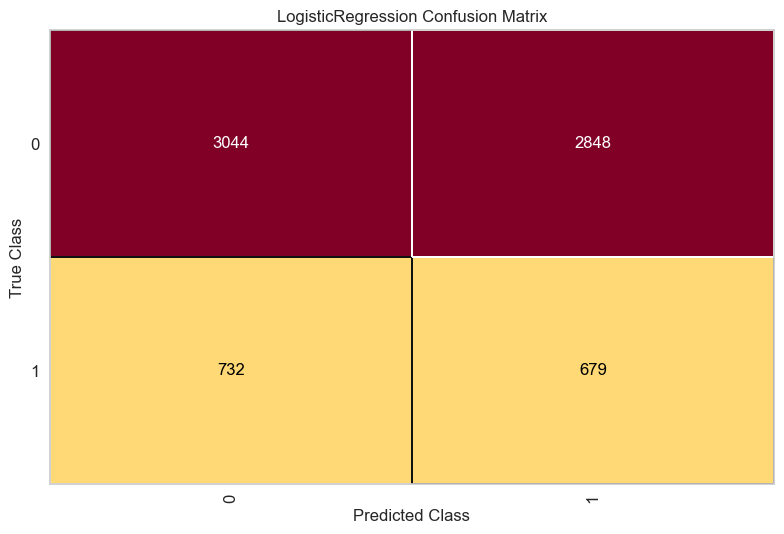

ConfusionMatrix(ax=<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x0000029A48BB3CD0>,
                estimator=LogisticRegression(C=2, class_weight='balanced',
                                             max_iter=200, tol=0.1))

In [115]:
# Plotando a matriz de confusão do modelo tunado
confusion_matrix(lr_tunned_model, X_train, y_train, X_test, y_test)

## Random Forest

In [207]:
# Treinando o modelo RandomForest
model = RandomForestClassifier(class_weight='balanced', random_state=2022)

rf = model.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

C:\Users\André\AppData\Local\Temp\ipykernel_576\3765624897.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = model.fit(X_train, y_train)


In [208]:
# Verificando a quantidade de churn e nao churn predita
pd.DataFrame(rf_pred).value_counts()

0    6752
1     551
dtype: int64

In [209]:
# Dados com a coluna de predicão
X_test.assign(churn = y_test).assign(label = rf.predict(X_test))

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard,churn,label
70870,0.509804,0.897477,1.0,0.00,0.75,0.4,1.0,0.0,0.0,1.0,0.0,0,0
2,0.509804,0.727709,0.6,0.25,0.00,0.2,0.0,1.0,0.0,1.0,0.0,1,0
13024,0.137255,0.000000,1.0,1.00,0.25,0.6,1.0,0.0,0.0,0.0,1.0,0,0
48045,0.372549,0.710355,0.2,0.00,0.75,0.8,0.0,1.0,0.0,1.0,0.0,0,0
15668,0.431373,0.998858,1.0,0.00,0.75,0.6,1.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30909,0.019608,0.393081,0.6,0.00,0.50,0.6,1.0,0.0,1.0,0.0,0.0,0,0
59589,0.647059,0.709213,0.2,0.00,0.25,0.8,1.0,0.0,1.0,0.0,0.0,0,0
50113,0.490196,0.270693,0.8,0.00,0.00,0.4,0.0,1.0,0.0,0.0,1.0,0,0
57582,0.470588,0.259733,0.2,0.00,0.25,0.0,0.0,1.0,0.0,0.0,1.0,1,0


c:\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


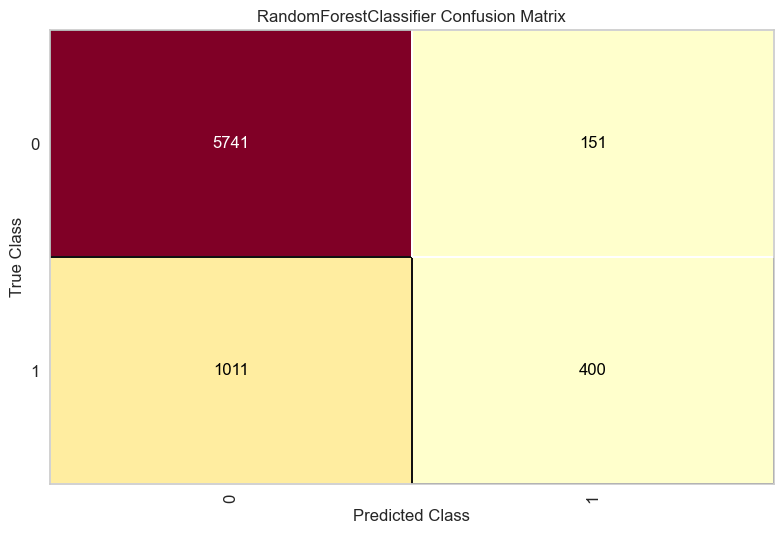

ConfusionMatrix(ax=<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x0000029A0EEFFD30>,
                estimator=RandomForestClassifier(class_weight='balanced',
                                                 random_state=2022))

In [210]:
# Plotando a matriz de confusão do modelo RandomForest
confusion_matrix(rf, X_train, y_train, X_test, y_test)

In [211]:
# Métricas dos dados de teste para o Random Forest
get_metrics(y_test, rf_pred)

{'Accuracy': 0.8408873065863344,
 'Balanced Accuracy': 0.6289294593012038,
 'Recall': 0.28348688873139616,
 'Precison': 0.7259528130671506,
 'F1': 0.40774719673802245,
 'ROC_AUC': 0.6289294593012039}

### Tunning Random Forest

In [212]:
# Tunning RandomForest
parameters = {'n_estimators': [100, 300, 500, 600, 800]}

grid_search = GridSearchCV(rf, parameters, scoring="accuracy", cv=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

c:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=2022),
             n_jobs=-1, param_grid={'n_estimators': [100, 300, 500, 600, 800]},
             scoring='accuracy')

In [213]:
# Melhores valores encontrados pelo GridSearch
df_grid_results = pd.DataFrame(grid_search.cv_results_).set_index('rank_test_score').sort_index()
df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')].head()

,mean_score_time,std_score_time,param_n_estimators,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,1.876551,0.000494,800,{'n_estimators': 800},0.815418,0.001506
2,0.825864,0.000268,300,{'n_estimators': 300},0.815008,0.001712
3,1.307511,0.003771,500,{'n_estimators': 500},0.814939,0.001780
4,1.525446,0.010471,600,{'n_estimators': 600},0.814905,0.001404
5,0.298468,0.002749,100,{'n_estimators': 100},0.813912,0.001164


In [214]:
# Parametros do melhor modelo
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2022,
 'verbose': 0,
 'warm_start': False}

In [215]:
# Treinando o melhor modelo
rf_tunned_model = grid_search.best_estimator_
rf_tunned_model.fit(X_train, y_train)

C:\Users\André\AppData\Local\Temp\ipykernel_576\2706696552.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_tunned_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=800,
                       random_state=2022)

In [216]:
# Métricas do Melhor Modelo
rf_tunned_pred = rf_tunned_model.predict(X_test)
get_metrics(y_test, rf_tunned_pred)

{'Accuracy': 0.8419827468163769,
 'Balanced Accuracy': 0.6290693503617922,
 'Recall': 0.2820694542877392,
 'Precison': 0.738404452690167,
 'F1': 0.4082051282051283,
 'ROC_AUC': 0.6290693503617922}

c:\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


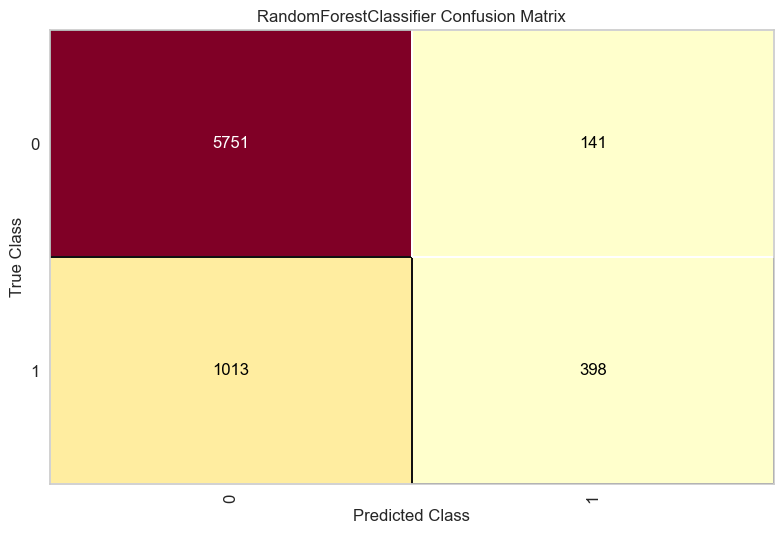

ConfusionMatrix(ax=<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x0000029A38B76B90>,
                estimator=RandomForestClassifier(class_weight='balanced',
                                                 n_estimators=800,
                                                 random_state=2022))

In [217]:
# Plotando a matriz de confusão do modelo tunado
confusion_matrix(rf_tunned_model, X_train, y_train, X_test, y_test)

# Evaluation

Analisando os dois modelos, o Random Forest obteve um desempenho superior quando comparado à Regressão Logística, atingindo 84,2% de acurácia no modelo com tunning de hiperparâmetros. 
Portanto, o Random Forest seria o modelo utilizado para prever se um usuário tem chance de cancelar a sua assinatura na plataforma ou não.